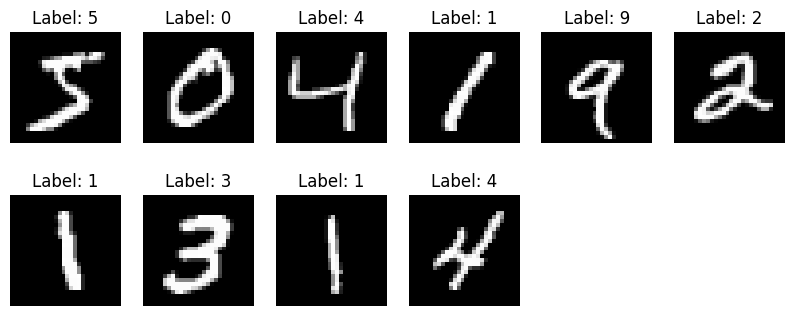

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import torch
import struct

def read_idx_gz(filename):
    with gzip.open(filename, 'rb') as file:
        zero, data_type, dims = struct.unpack('>HBB', file.read(4))
        shape = tuple(struct.unpack('>I', file.read(4))[0] for d in range(dims))
        return np.frombuffer(file.read(), dtype=np.uint8).reshape(shape)

def find_labels(images, labels, target_labels, num_each):
    found = {label: 0 for label in target_labels}
    indices = []

    for i, label in enumerate(labels):
        if label in target_labels and found[label] < num_each:
            indices.append(i)
            found[label] += 1
            if all(found[l] >= num_each for l in target_labels):
                break

    return indices

# File paths
train_images_content = 'train-images-idx3-ubyte.gz'
train_labels_content = 'train-labels-idx1-ubyte.gz'
test_images_content = 't10k-images-idx3-ubyte.gz'
test_labels_content = 't10k-labels-idx1-ubyte.gz'

# Read the data
data_train = read_idx_gz(train_images_content)
data_tags = read_idx_gz(train_labels_content)
test_images = read_idx_gz(test_images_content)
test_tags = read_idx_gz(test_labels_content)

# Display the first 10 images
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_train[i], cmap='gray')
    plt.title(f"Label: {data_tags[i]}")
    plt.axis('off')



In [63]:

# Normalize the image data
train_images = data_train / 255.0
test_images = test_images / 255.0



In [64]:
print(train_images.shape,data_tags.shape,test_images.shape,test_tags.shape)
print(train_images.ndim,data_tags.ndim,test_images.ndim,test_tags.ndim)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
3 1 3 1


In [65]:
def find_batch(roll_number):
    A = int(roll_number[-3:])
    if A % 2 == 0:
        return 32
    elif A % 3 == 0:
        return 16
    else:
        return 20

roll_number = 'p23cs0010'
batch_size = find_batch(roll_number)
print(batch_size)

32


In [66]:

from torch.utils.data import TensorDataset, DataLoader, random_split



# Convert to torch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).reshape(60000,1,28,28)
train_labels = torch.tensor(data_tags, dtype=torch.long).reshape(60000)
test_images = torch.tensor(test_images, dtype=torch.float32).reshape(10000,1,28,28)
test_labels = torch.tensor(test_tags, dtype=torch.long).reshape(10000)

# Create a TensorDataset for the training data
train_dataset = TensorDataset(train_images, train_labels)

# Determine the split sizes
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

# Randomly split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoaders for training and validation sets
batch_size = 32  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Test set (already loaded and normalized)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
len(train_loader),len(test_loader),len(validation_loader)
# Now you can use train_loader, validation_loader, and test_loader in your training loop


(1500, 313, 375)

In [67]:
len(train_loader),len(test_loader), len(validation_loader)

(1500, 313, 375)

In [68]:
print(train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [69]:
import torch.nn as nn
import torch.nn.functional as F
class MYY_CNN(nn.Module):
    def __init__(self, num_classes):
        super(MYY_CNN, self).__init__()
        # Convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)

        # Convolution layer 3
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Output layer
        self.fc = nn.Linear(4 * 2* 2, num_classes)  # Adjust the linear layer input size according to your input image size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 2 * 2)  # Flatten the tensor for the fully connected layer
        x = F.softmax(x, dim=1)
        return x # Apply softmax to the output layer

In [70]:

import torch.optim as optim
import torch.nn as nn

# Assuming MYY_CNN is your model class and train_loader, validation_loader are defined elsewhere

def train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss = total_loss / len(validation_loader)
        validation_accuracy = 100 * correct_val / total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch_no {epoch + 1}/{epochs} - "
              f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_accuracy:.2f}% - "
              f"Validation_Loss: {validation_loss:.4f}, Validation_Acc: {validation_accuracy:.2f}%")

    return train_losses, train_accuracies, validation_losses, validation_accuracies

# Example usage
num_classes = 10  # Example for MNIST dataset
model = MYY_CNN(num_classes)  # Replace MYY_CNN with your actual model class

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Replace 'train_loader' and 'validation_loader' with your actual data loaders
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
    model, criterion, optimizer, train_loader, validation_loader, epochs=15
)


Epoch_no 1/15 - Train_Loss: 2.4488, Train_Acc: 43.12% - Validation_Loss: 2.4029, Validation_Acc: 47.02%
Epoch_no 2/15 - Train_Loss: 2.3318, Train_Acc: 54.59% - Validation_Loss: 2.2442, Validation_Acc: 63.56%
Epoch_no 3/15 - Train_Loss: 2.2266, Train_Acc: 65.15% - Validation_Loss: 2.2255, Validation_Acc: 65.00%
Epoch_no 4/15 - Train_Loss: 2.2132, Train_Acc: 66.29% - Validation_Loss: 2.2165, Validation_Acc: 65.84%
Epoch_no 5/15 - Train_Loss: 2.2067, Train_Acc: 66.89% - Validation_Loss: 2.2126, Validation_Acc: 66.14%
Epoch_no 6/15 - Train_Loss: 2.2043, Train_Acc: 67.01% - Validation_Loss: 2.2109, Validation_Acc: 66.35%
Epoch_no 7/15 - Train_Loss: 2.2009, Train_Acc: 67.36% - Validation_Loss: 2.2051, Validation_Acc: 66.91%
Epoch_no 8/15 - Train_Loss: 2.1987, Train_Acc: 67.58% - Validation_Loss: 2.2052, Validation_Acc: 66.84%
Epoch_no 9/15 - Train_Loss: 2.1962, Train_Acc: 67.82% - Validation_Loss: 2.2033, Validation_Acc: 67.05%
Epoch_no 10/15 - Train_Loss: 2.1951, Train_Acc: 67.88% - Validat

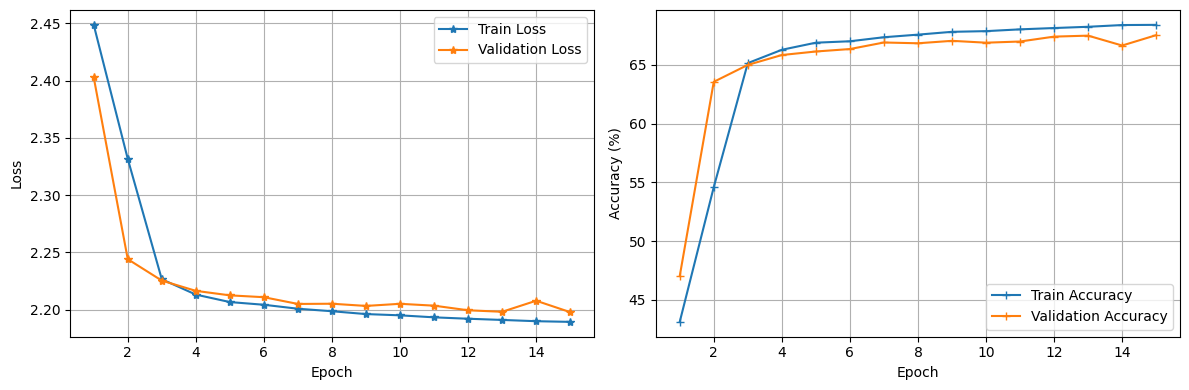

Sample Image Shape from Test Loader: torch.Size([32, 1, 28, 28])


In [71]:


def analysis_model(model, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs):
    # Plotting the training and validation losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='*')
    plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker='*')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='+')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy', marker='+')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Displaying a sample image shape from test loader
    images, _ = next(iter(test_loader))
    print(f"Sample Image Shape from Test Loader: {images.shape}")




analysis_model(model, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs=15)


In [72]:
def cal_parameters(model):
    total_params = 0
    trainable_params = 0

    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # For Conv2d and Linear layers, count weights and biases
            weights = layer.weight.numel()
            total_params += weights
            if layer.weight.requires_grad:
                trainable_params += weights

            if layer.bias is not None:
                biases = layer.bias.numel()
                total_params += biases
                if layer.bias.requires_grad:
                    trainable_params += biases

        elif isinstance(layer, nn.Sequential):
            # If the layer is Sequential, recursively count its parameters
            sub_total, sub_trainable = calculate_parameters(layer)
            total_params += sub_total
            trainable_params += sub_trainable

    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

# Example usage
# model = MYY_CNN(num_classes=10)  # Replace with your model
total_params, trainable_params, non_trainable_params = cal_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")


Total Parameters: 4470
Trainable Parameters: 4470
Non-Trainable Parameters: 0


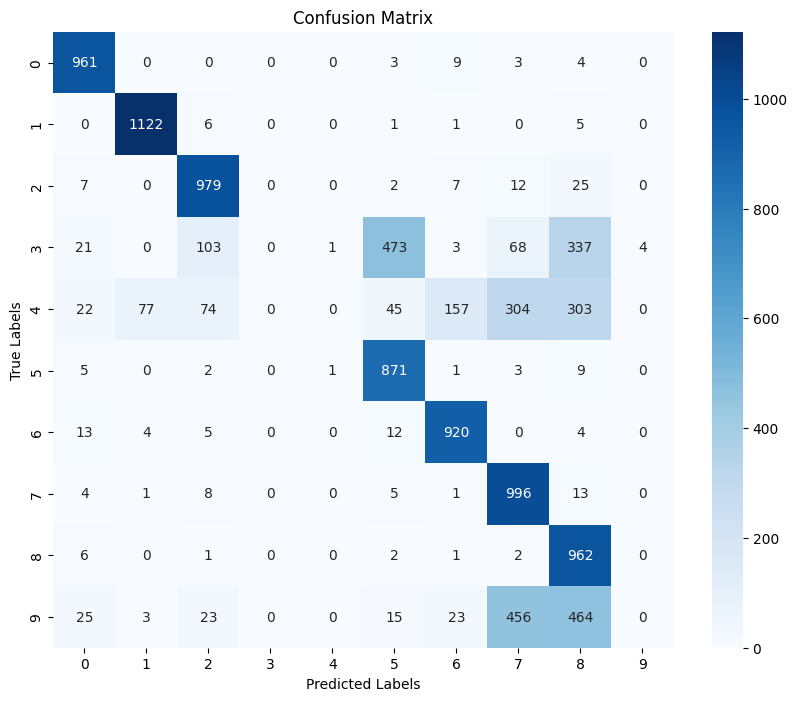

In [73]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


def compute_confusion_matrix(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients for validation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    conf_matrix = confusion_matrix(all_labels, all_predicted)
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
conf_matrix = compute_confusion_matrix(model, test_loader)
plot_confusion_matrix(conf_matrix)


In [74]:
# Test
model.eval()
total_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_error = 100 - test_accuracy

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Error: {test_error:.2f}%")


Test Loss: 2.1919, Test Accuracy: 68.11%, Test Error: 31.89%


In [75]:
def report_of_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

# Example usage
report_of_parameters(model)


Total Parameters: 4470
Trainable Parameters: 4470
Non-Trainable Parameters: 0



# Define the class mapping:


In [76]:
import torch

class_mapping = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}

# Assuming train_labels and test_labels are PyTorch tensors containing the labels
# and train_images and test_images are PyTorch tensors containing the image data.

# Filter and relabel train dataset
train_indices = [i for i, label in enumerate(train_labels) if label.item() in class_mapping]
train_images = train_images[train_indices]
train_labels = torch.tensor([class_mapping[label.item()] for label in train_labels[train_indices]], dtype=torch.long)

# Filter and relabel test dataset
test_indices = [i for i, label in enumerate(test_labels) if label.item() in class_mapping]
test_images = test_images[test_indices]
test_labels = torch.tensor([class_mapping[label.item()] for label in test_labels[test_indices]], dtype=torch.long)


In [77]:

# Normalize the image data to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [78]:
print(train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)
print(train_images.ndim,train_labels.ndim,test_images.ndim,test_labels.ndim)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])
4 1 4 1


In [79]:

from torch.utils.data import TensorDataset, DataLoader, random_split



# Convert to torch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).reshape(60000,1,28,28)
train_labels = torch.tensor(data_tags, dtype=torch.long).reshape(60000)
test_images = torch.tensor(test_images, dtype=torch.float32).reshape(10000,1,28,28)
test_labels = torch.tensor(test_tags, dtype=torch.long).reshape(10000)

# Create a TensorDataset for the training data
train_dataset = TensorDataset(train_images, train_labels)

# Determine the split sizes
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

# Randomly split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoaders for training and validation sets
batch_size = 32  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Test set (already loaded and normalized)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
len(train_loader),len(test_loader),len(validation_loader)
# Now you can use train_loader, validation_loader, and test_loader in your training loop


<ipython-input-79-8134898da538>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images = torch.tensor(train_images, dtype=torch.float32).reshape(60000,1,28,28)
<ipython-input-79-8134898da538>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_images = torch.tensor(test_images, dtype=torch.float32).reshape(10000,1,28,28)


(1500, 313, 375)

In [80]:
import torch.nn as nn
import torch.nn.functional as F
class MYY_CNN(nn.Module):
    def __init__(self, num_classes):
        super(MYY_CNN, self).__init__()
        # Convolution layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolution layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)

        # Convolution layer 3
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Output layer
        self.fc = nn.Linear(4 * 2* 2, num_classes)  # Adjust the linear layer input size according to your input image size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 2 * 2)  # Flatten the tensor for the fully connected layer
        x = F.softmax(x, dim=1)
        return x # Apply softmax to the output layer

In [81]:

import torch.optim as optim
import torch.nn as nn

# Assuming MYY_CNN is your model class and train_loader, validation_loader are defined elsewhere

def train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        validation_loss = total_loss / len(validation_loader)
        validation_accuracy = 100 * correct_val / total_val
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        print(f"Epoch_no {epoch + 1}/{epochs} - "
              f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_accuracy:.2f}% - "
              f"Validation_Loss: {validation_loss:.4f}, Validation_Acc: {validation_accuracy:.2f}%")

    return train_losses, train_accuracies, validation_losses, validation_accuracies

# Example usage
num_classes = 4  # Example for MNIST dataset
model = MYY_CNN(num_classes)  # Replace MYY_CNN with your actual model class

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Replace 'train_loader' and 'validation_loader' with your actual data loaders
train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
    model, criterion, optimizer, train_loader, validation_loader, epochs=20
)


Epoch_no 1/20 - Train_Loss: 2.7238, Train_Acc: 15.19% - Validation_Loss: 2.6788, Validation_Acc: 21.18%
Epoch_no 2/20 - Train_Loss: 2.6519, Train_Acc: 22.78% - Validation_Loss: 2.6298, Validation_Acc: 24.81%
Epoch_no 3/20 - Train_Loss: 2.6132, Train_Acc: 26.56% - Validation_Loss: 2.6056, Validation_Acc: 26.98%
Epoch_no 4/20 - Train_Loss: 2.5964, Train_Acc: 27.95% - Validation_Loss: 2.5917, Validation_Acc: 28.35%
Epoch_no 5/20 - Train_Loss: 2.5791, Train_Acc: 29.56% - Validation_Loss: 2.5450, Validation_Acc: 33.52%
Epoch_no 6/20 - Train_Loss: 2.5241, Train_Acc: 35.55% - Validation_Loss: 2.5024, Validation_Acc: 37.51%
Epoch_no 7/20 - Train_Loss: 2.4987, Train_Acc: 37.75% - Validation_Loss: 2.4879, Validation_Acc: 38.65%
Epoch_no 8/20 - Train_Loss: 2.4876, Train_Acc: 38.66% - Validation_Loss: 2.4807, Validation_Acc: 39.22%
Epoch_no 9/20 - Train_Loss: 2.4816, Train_Acc: 39.12% - Validation_Loss: 2.4757, Validation_Acc: 39.58%
Epoch_no 10/20 - Train_Loss: 2.4313, Train_Acc: 44.93% - Validat

In [82]:
def cal_parameters(model):
    total_params = 0
    trainable_params = 0

    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # For Conv2d and Linear layers, count weights and biases
            weights = layer.weight.numel()
            total_params += weights
            if layer.weight.requires_grad:
                trainable_params += weights

            if layer.bias is not None:
                biases = layer.bias.numel()
                total_params += biases
                if layer.bias.requires_grad:
                    trainable_params += biases

        elif isinstance(layer, nn.Sequential):
            # If the layer is Sequential, recursively count its parameters
            sub_total, sub_trainable = calculate_parameters(layer)
            total_params += sub_total
            trainable_params += sub_trainable

    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

# Example usage
# model = MYY_CNN(num_classes=10)  # Replace with your model
total_params, trainable_params, non_trainable_params = cal_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")


Total Parameters: 4368
Trainable Parameters: 4368
Non-Trainable Parameters: 0


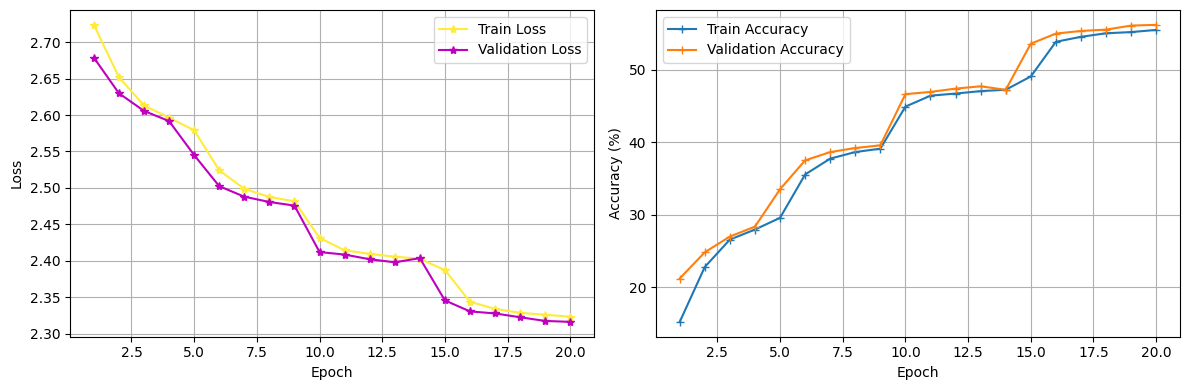

Sample Image Shape from Test Loader: torch.Size([32, 1, 28, 28])


In [83]:



def analyze_model_performance(model, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs):
    # Plotting the training and validation losses and accuracies
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='*',color=(1.0, 0.92, 0.23))
    plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss', marker='*', color='m')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', marker='+')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy', marker='+')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Displaying a sample image shape from test loader
    images, _ = next(iter(test_loader))
    print(f"Sample Image Shape from Test Loader: {images.shape}")



# Example usage
analyze_model_performance(model, train_losses, validation_losses, train_accuracies, validation_accuracies, test_loader, epochs=20)


In [84]:
# Test
model.eval()
total_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = total_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
test_error = 100 - test_accuracy

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Error: {test_error:.2f}%")


Test Loss: 2.3097, Test Accuracy: 56.69%, Test Error: 43.31%


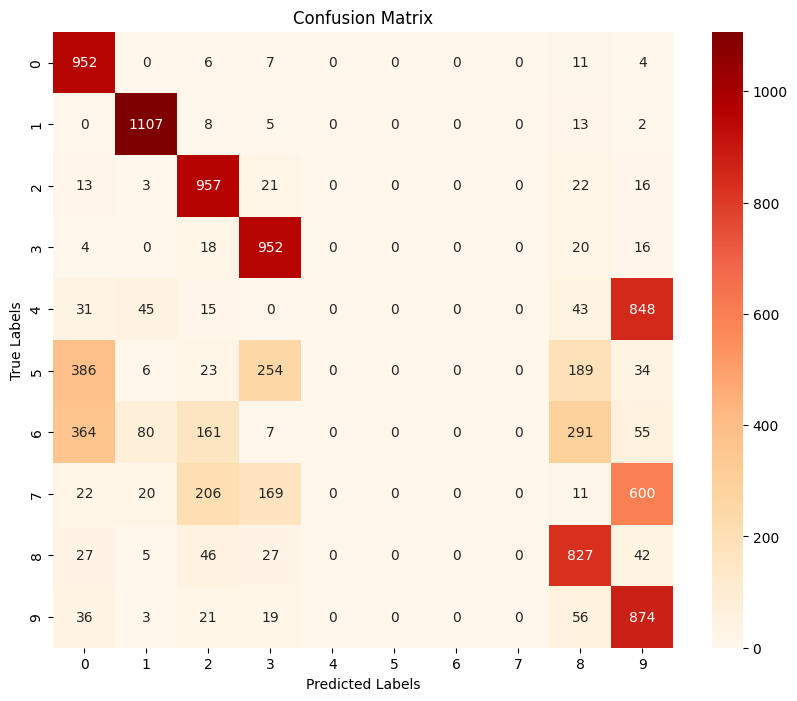

In [85]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predicted = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients for validation
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    conf_matrix = confusion_matrix(all_labels, all_predicted)
    return conf_matrix

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="OrRd")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
conf_matrix = compute_confusion_matrix(model, test_loader)
plot_confusion_matrix(conf_matrix)


In [86]:
def report_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

# Example usage
report_model_parameters(model)


Total Parameters: 4368
Trainable Parameters: 4368
Non-Trainable Parameters: 0


In [87]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
#Regularization: L2 regularization (also known as weight decay in the context of neural networks) can be added to the optimizer. It encourages the model weights to be small, which can prevent overfitting.

In [ ]:
import idx2numpy
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MNISTDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = idx2numpy.convert_from_file(image_file)
        self.labels = idx2numpy.convert_from_file(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNISTDataset('path/to/train-images-idx3-ubyte', 'path/to/train-labels-idx1-ubyte', transform=transform)
test_dataset = MNISTDataset('path/to/t10k-images-idx3-ubyte', 'path/to/t10k-labels-idx1-ubyte', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the CNN with Dropout for Regularization
class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))
        self.fc = nn.Linear(7 * 7 * 64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Load and Transform the MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])



trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Model, Loss Function, and Optimizer with Weight Decay
model = MyCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training and Validation Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} completed.")

# Evaluation
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Count Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


NameError: name 'trainset' is not defined